In [1]:
from scipy.stats import poisson
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product

sns.set()
sns.set_context('talk')

### Chargaff's second party rule test

We will model the number of kmer occurences as a poisson random variable.

Lets say there are 3 billion bases in the human genome

In [2]:
n=3000000000
print(f'Number of samples = length of genome {n}')

k = 6
print(f"Length of kmer {k}")

number_of_kmers = 4**k
print(f"Total number of diverse kmers {number_of_kmers}")

probability_of_kmer=1/number_of_kmers
print(f"probability of kmer occurence {probability_of_kmer}")

expected_count = probability_of_kmer * n
print(f'expected number of kmers {expected_count}')

Number of samples = length of genome 3000000000
Length of kmer 6
Total number of diverse kmers 4096
probability of kmer occurence 0.000244140625
expected number of kmers 732421.875


## Empirical test

Sample from poisson distribution count of kmer and it's reverse compliment. Then subtract the two and check the percentage. Plot the distribution of percentages

In [3]:
diffs = []
for i in range(int(number_of_kmers/2)):
    first_kmer = np.random.poisson(732421)
    second_kmer = np.random.poisson(732421)
    # Second kmer isn't really independent of the first one 
    # since the presence of the sequences decreases the sample size due to 
    # having fewer sequences to choose from + overlap with the first set of
    # sequences

    # For the simplicity of the calculation I will however assume they are 
    # independent
    bigger_count = np.mean([first_kmer, second_kmer])
    percent_diff = np.abs(first_kmer - second_kmer)/ bigger_count
    diffs.append(percent_diff)

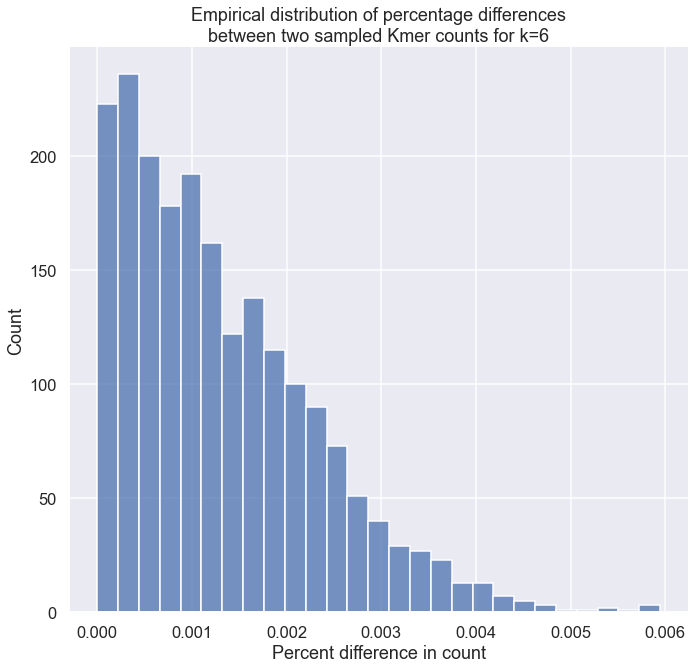

In [4]:
sns.displot(diffs,height=10)
plt.xlabel('Percent difference in count') 
plt.title('Empirical distribution of percentage differences\n\
between two sampled Kmer counts for k=6')
plt.subplots_adjust(top=0.85)
plt.savefig('./empirical_diff.png')

### Theoretical test

Subtract CDF of poisson RV at lower bound (expected value - 1%) from CDF of poisson RV at upper bound (expected value + 1%)

In [5]:
upper_k = expected_count + expected_count/100
lower_k = expected_count - expected_count/100
f"expected count +1% {upper_k}"
f"expected count -1% {lower_k}"
p_upper_k = poisson.cdf(mu=expected_count, k = upper_k)
p_lower_k = poisson.cdf(mu=expected_count, k = lower_k)

f"probability of observing a kmer count\
between upper bound: {int(upper_k)}\
and lower bound {int(lower_k)}\
 defined by 1 higher and lower of expected count%\
 {p_upper_k - p_lower_k} \
 under poisson distribution with lambda = {int(expected_count)}"

'probability of observing a kmer countbetween upper bound: 739746and lower bound 725097 defined by 1 higher and lower of expected count% 1.0  under poisson distribution with lambda = 732421'

In [6]:
kernel_size=6
kmer_count = {"".join(x):0 for x in product(['A','C','T','G'], repeat=kernel_size)}
fgenome = np.random.choice(['A', 'C', 'T', 'G'], 100000000)

In [7]:
%timeit
for i in range(len(fgenome) - kernel_size):
    if i%10000000 == 0:
        print(i)
    kmer_count["".join(fgenome[i:i+kernel_size])] += 1

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000


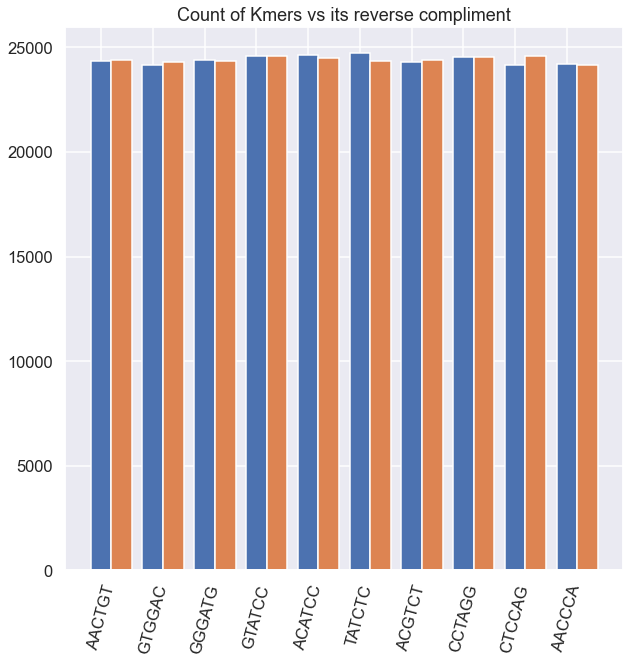

In [8]:
random_kmers = np.random.choice(list(kmer_count.keys()), 10)
rc_dict = {
    "A":"T",
    'T':'A',
    'G':'C',
    'C':'G',
}
plt.figure(figsize=(10,10))
rc_random_kmers = ["".join([rc_dict[a] for a in x][::-1]) for x in random_kmers]
plt.bar(range(len(rc_random_kmers)), [kmer_count[x] for x in rc_random_kmers], width=.4)
plt.bar(np.arange(.4, len(random_kmers)+.4, 1), [kmer_count[x] for x in random_kmers], width=.4)
plt.xticks(labels=random_kmers, ticks=np.arange(len(random_kmers)), rotation=75);
plt.title('Count of Kmers vs its reverse compliment')
plt.savefig("bar_kmer_rc_counts.png")

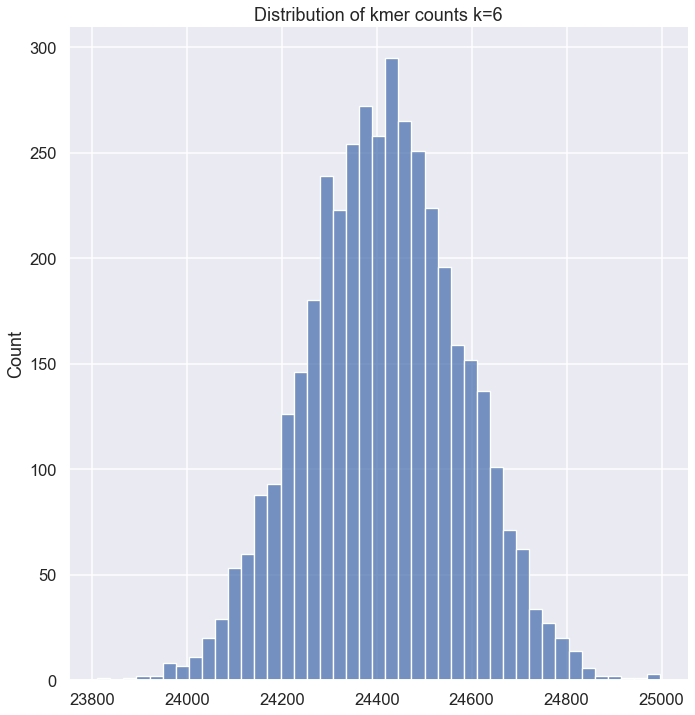

In [9]:
sns.displot(list(kmer_count.values()), height=10)
plt.title(f'Distribution of kmer counts k={kernel_size}')
plt.savefig('dist_kmer_counts.png')

In [10]:
kmers = list(kmer_count.keys())
rc_kmers = ["".join([rc_dict[a] for a in x][::-1]) for x in kmers]
counts_zipped = list(zip([kmer_count[x] for x in rc_kmers], [kmer_count[x] for x in kmers]))
true_var = np.mean([np.var(x) for x in counts_zipped])
true_var

13116.006958007812

In [11]:
variances = []
kmers = list(kmer_count.keys())
kmer_static_count = [kmer_count[x] for x in kmers]
random_kmers = np.copy(kmers)

for i in range(10000):
    if i %1000 == 0:
        print(i)
    np.random.shuffle(random_kmers)
    counts_zipped = list(zip([kmer_count[x] for x in random_kmers], kmer_static_count))
    variances.append(np.mean(np.var(counts_zipped,axis=-1)))

0
100
200
300
400
500
600
700
800
900


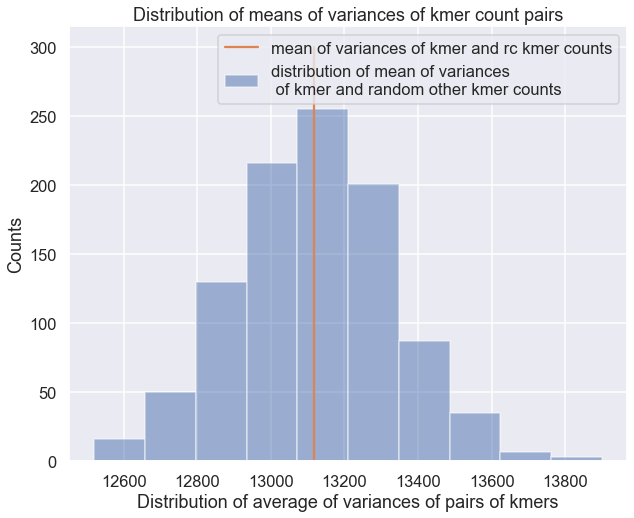

In [12]:
plt.figure(figsize=(10,8))
plt.hist(variances, alpha=0.5, label='distribution of mean of variances\n of kmer and random other kmer counts')
plt.plot([true_var, true_var],[0,300], label='mean of variances of kmer and rc kmer counts')
plt.xlabel('Distribution of average of variances of pairs of kmers')
plt.ylabel('Counts')
plt.title('Distribution of means of variances of kmer count pairs')
plt.legend()
plt.savefig('dist_means_variances_kmer_count_pairs.png')